## `+` Import Libraries

In [1]:
import gdown
import os
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose, Concatenate

# `+` Seed Value

In [2]:
SEED = 907
batch_size = 10
epochs = 20

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [3]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=130ec964-322f-487a-8687-14c18a11317c
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:00<00:00, 44.5MB/s]


'Lung_Data.zip'

In [4]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset


In [5]:
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [6]:
# Training Dataset
grey_train_ds, grey_val_ds = image_dataset_from_directory('Lung_Data_PNG/grey',
                                                batch_size=batch_size,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [7]:
# Validation Dataset
mask_train_ds, mask_val_ds = image_dataset_from_directory('Lung_Data_PNG/mask',
                                                batch_size=batch_size,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


### Preview the Images

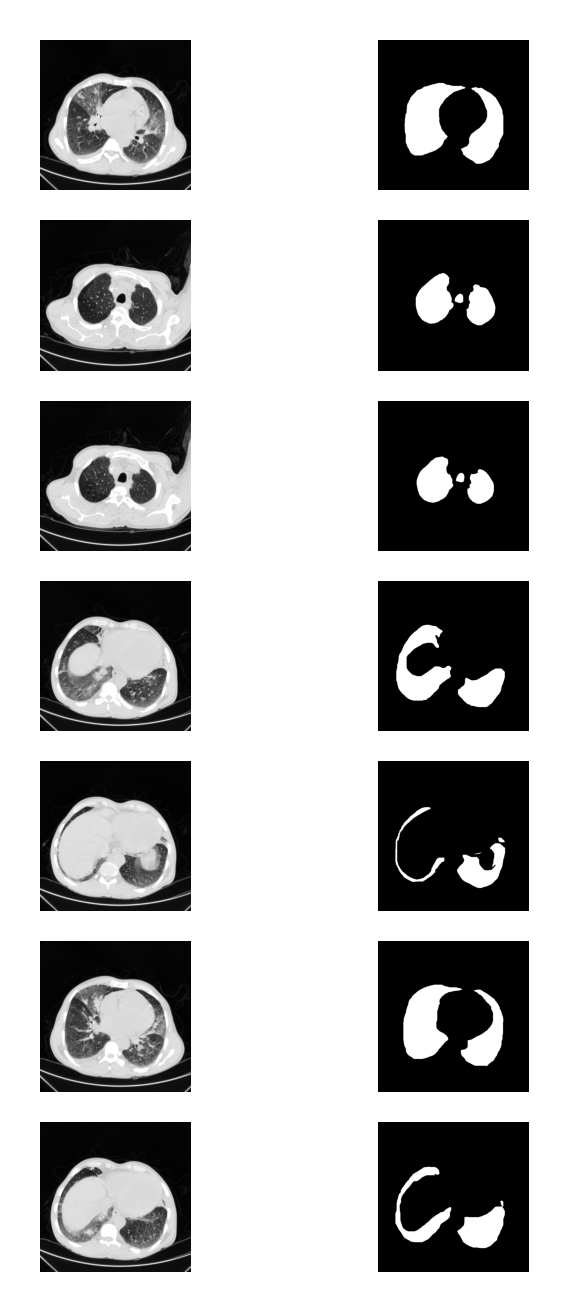

In [8]:
# Preview Images
plt.figure(figsize=(2, 4), dpi=400)
for images, masks in zip(grey_train_ds.take(6), mask_train_ds.take(6)):
    for i in range(7):
        plt.subplot(7, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(7, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')

## `i` Model Design

In [9]:
def double_conv_block(x, n_filters):
  x = Conv2D(n_filters , (3,3) , activation='relu' , padding='same' , kernel_initializer='he_normal')(x)
  x = Conv2D(n_filters , (3,3) , activation='relu' , padding='same' , kernel_initializer='he_normal')(x)
  return x

In [10]:
def downsampling_block(x , n_filters):
  f = double_conv_block(x , n_filters)
  p = MaxPool2D()(f)
  return f , p

In [11]:
def upsampling_block(x , n_filters , skip_features):
  x = Conv2DTranspose(n_filters , (3,3) , 2 , padding='same')(x)
  x = Concatenate()([x , skip_features])
  x = double_conv_block(x , n_filters)
  return x

## `ii` Model Structure

In [12]:
inputs = Input(shape=(512, 512, 1))
scaled_inputs = Rescaling(1./255)(inputs)

f1 , p1 = downsampling_block(scaled_inputs , 32)
f2 , p2 = downsampling_block(p1 , 64)
f3 , p3 = downsampling_block(p2 , 128)
f4 , p4 = downsampling_block(p3 , 256)

bottleneck = double_conv_block(p4 , 512)

u1 = upsampling_block(bottleneck , 256 , f4)
u2 = upsampling_block(u1 , 128 , f3)
u3 = upsampling_block(u2 , 64 , f2)
u4 = upsampling_block(u3 , 32 , f1)

output = Conv2D(1 , (1,1) , activation='sigmoid' , padding='same')(u4)

model = Model(inputs , output , name = 'UNet')
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_9[0][0]  

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

## `iii` Model Compilation & Training

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
segment_train = tf.data.Dataset.zip(
    (grey_train_ds, mask_train_ds.map(lambda x: tf.cast(x, tf.float32) / 255.0))
)

segment_val = tf.data.Dataset.zip(
    (grey_val_ds, mask_val_ds.map(lambda x: tf.cast(x, tf.float32) / 255.0))
)


In [15]:
history = model.fit(x = segment_train ,
                    validation_data= segment_val ,
                    epochs=epochs ,
                    steps_per_epoch = grey_train_ds.cardinality().numpy(),
                    validation_steps = grey_val_ds.cardinality().numpy())

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.7361 - loss: 0.4934 - val_accuracy: 0.8835 - val_loss: 0.4005
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 738ms/step - accuracy: 0.8935 - loss: 0.3860 - val_accuracy: 0.8835 - val_loss: 0.3801
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 732ms/step - accuracy: 0.8921 - loss: 0.3413 - val_accuracy: 0.8835 - val_loss: 0.2558
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 730ms/step - accuracy: 0.8926 - loss: 0.2805 - val_accuracy: 0.8835 - val_loss: 0.2413
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 735ms/step - accuracy: 0.8882 - loss: 0.2284 - val_accuracy: 0.8835 - val_loss: 0.2389
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 769ms/step - accuracy: 0.8856 - loss: 0.2257 - val_accuracy: 0.8835 - val_loss: 0.2264
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 744ms/step - accuracy: 0.8870 - loss: 0.2192 - val_accuracy: 0.8835 - val_loss: 0.2170
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 730ms/step - accuracy: 0.8908 - loss: 0.2100 - val_accura

## `iv` Model Evaluation

In [16]:
train_loss , train_accuracy = model.evaluate(segment_train)
val_loss , val_accuracy = model.evaluate(segment_val)
print(f'Train Accuracy: {train_accuracy*100:.2f}%')
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 789ms/step - accuracy: 0.9875 - loss: 0.0381
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.9876 - loss: 0.0379
Train Accuracy: 98.84%
Validation Accuracy: 98.83%


## `v` Result Visualization

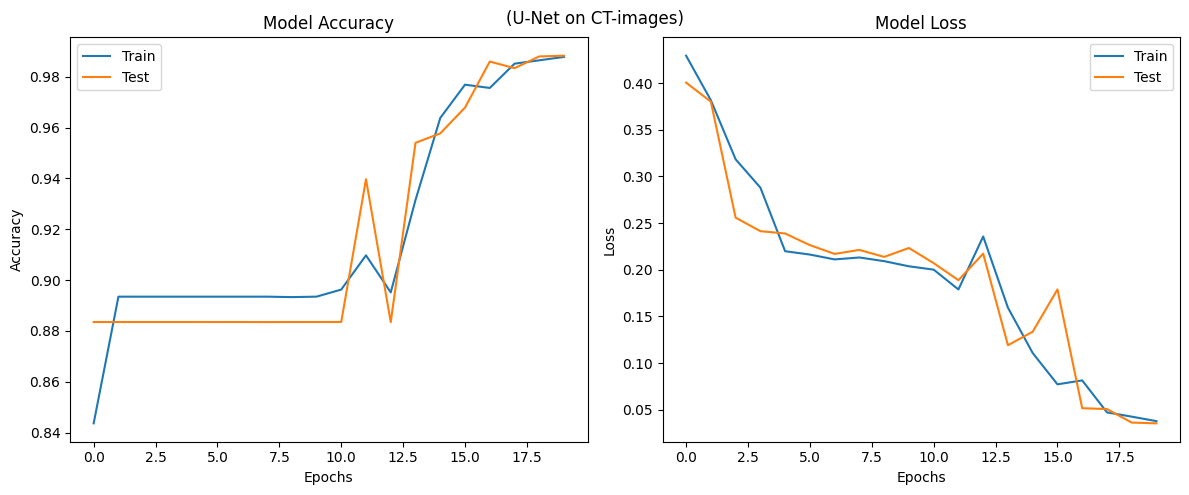

In [17]:
# Plot the training and validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Accuracy subplot
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'])

# Loss subplot
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'])

# Adjust layout and show
plt.tight_layout()
fig.suptitle('(U-Net on CT-images)')
plt.show()


## `vi` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


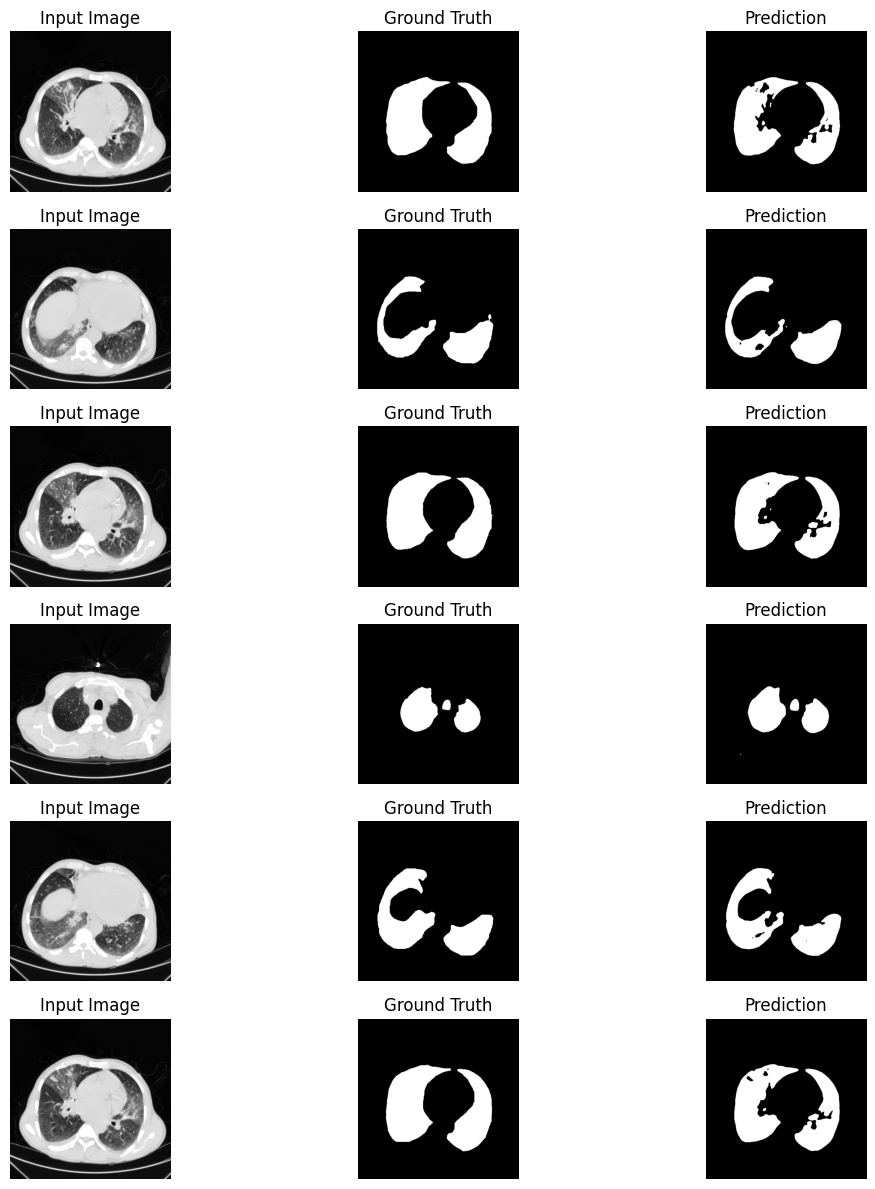

In [18]:
# Plot the Input, True Mask, and Predicted Mask
# Get one batch from validation datasets
images = next(iter(grey_val_ds))
masks = next(iter(mask_val_ds))

# Predict masks
preds = model.predict(images)

preds_thresholded = (preds > 0.5).astype("float32")

# Display the first 6 samples
num_samples = 6
plt.figure(figsize=(12, num_samples * 2))

for i in range(num_samples):
    # Original image
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Ground truth mask
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # Predicted mask
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(preds_thresholded[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [19]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   243M      0  0:00:03  0:00:03 --:--:--  243M


In [20]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [21]:
SEED = 907
BATCH_SIZE  = 10
EPOCHS      = 20

In [22]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Load & Preprocess the Dataset


In [23]:
# Training/Validation Dataset
train_ds, val_ds = image_dataset_from_directory('PetImages',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(180,180),
                                                validation_split=0.2,
                                                subset="both")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


### Preview the Images

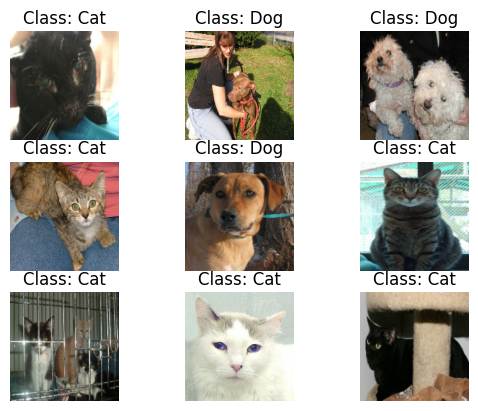

In [ ]:
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')
    plt.axis('off')

# Using `Pre-Trained` model

## `i` Model Design

In [25]:
from tensorflow.keras.applications import ResNet50 , InceptionV3


In [26]:
ResNet_pretrained = ResNet50(weights='imagenet', include_top=False, pooling = 'avg' )
for layer in ResNet_pretrained.layers:
    layer.trainable = False
ResNet_pretrained.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [27]:
model = Sequential()
model.add(Input(shape=(180, 180, 3)))
model.add(RandomFlip())
model.add(RandomRotation(0.3))
model.add(ResNet_pretrained)
model.add(Dense(64, activation='relu'))
model.add(Dense(1 , activation='sigmoid'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,913 (90.48 MB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## `ii` Model Compilation & Training

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(x=train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - accuracy: 0.8586 - loss: 0.3157 - val_accuracy: 0.9276 - val_loss: 0.1829
Epoch 2/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 136s 46ms/step - accuracy: 0.9029 - loss: 0.2286 - val_accuracy: 0.9584 - val_loss: 0.1025
Epoch 3/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 147s 49ms/step - accuracy: 0.9081 - loss: 0.2151 - val_accuracy: 0.9611 - val_loss: 0.0948
Epoch 4/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 142s 49ms/step - accuracy: 0.9171 - loss: 0.1995 - val_accuracy: 0.9594 - val_loss: 0.0965
Epoch 5/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 87s 46ms/step - accuracy: 0.9178 - loss: 0.1957 - val_accuracy: 0.9588 - val_loss: 0.1036
Epoch 6/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 142s 46ms/step - accuracy: 0.9250 - loss: 0.1845 - val_accuracy: 0.9645 - val_loss: 0.0879
Epoch 7/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 147s 49ms/step - accuracy: 0.9244 - loss: 0.1833 - val_accuracy: 0.9622 - val_loss: 0.0976
Epoch 8/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 142s 49ms/step - accuracy: 0

## `iii` Model Evaluation

In [30]:
train_loss , train_accuracy = model.evaluate(train_ds)
val_loss , val_accuracy = model.evaluate(val_ds)
print(f'Train Accuracy: {train_accuracy*100:.2f}%')
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

1873/1873 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - accuracy: 0.9719 - loss: 0.0702
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9631 - loss: 0.0915
Train Accuracy: 97.49%
Validation Accuracy: 96.31%


## `iv` Result Visualization

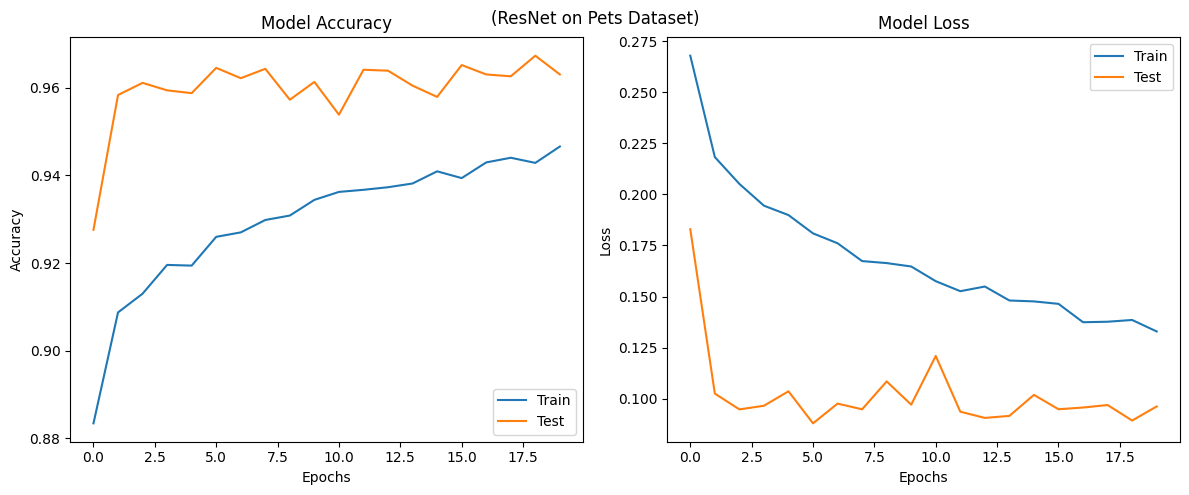

In [33]:
# Plot the training and validation accuracy and loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Accuracy subplot
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Test'])

# Loss subplot
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'])

# Adjust layout and show
plt.tight_layout()
fig.suptitle('(ResNet on Pets Dataset)')
plt.show()

## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


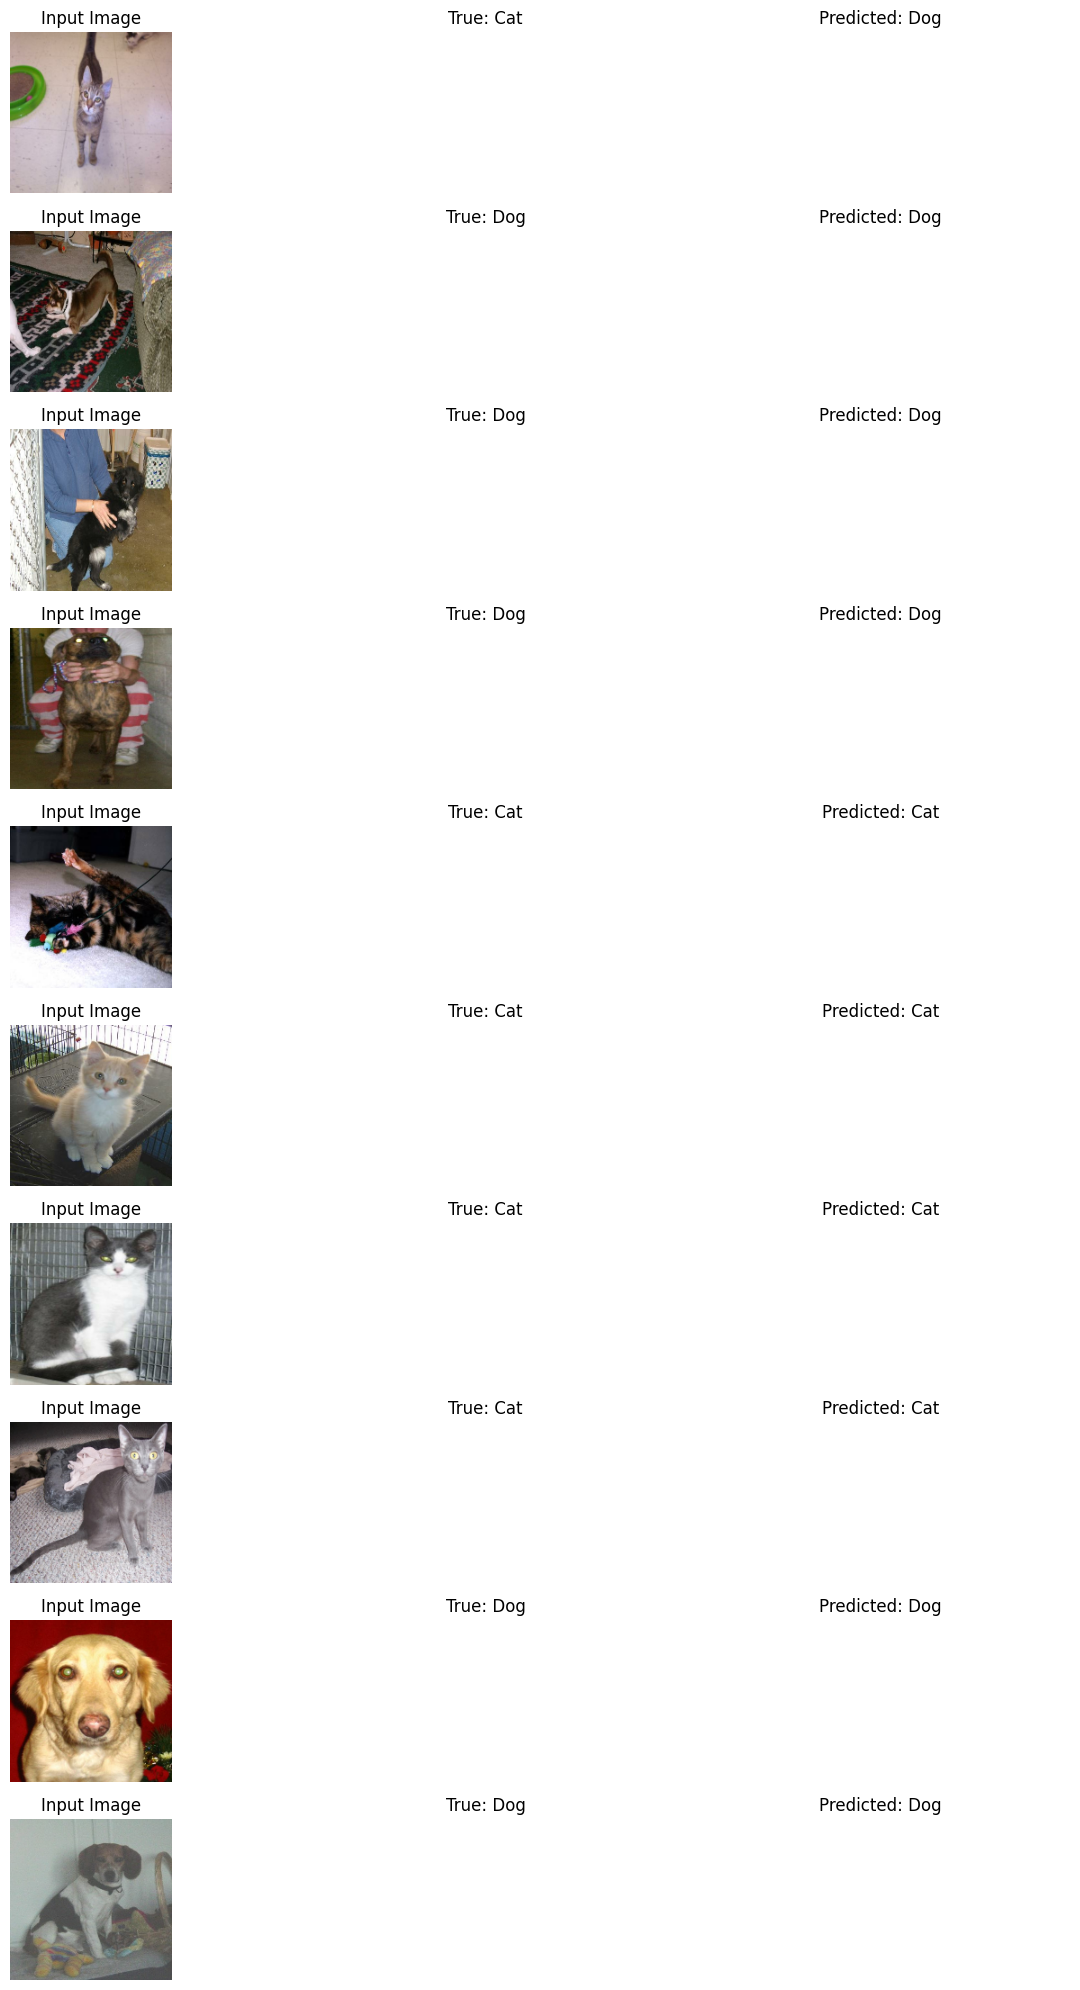

In [32]:
# Get a batch from the validation dataset
images, true_labels = next(iter(val_ds))

predictions = model.predict(images)
preds_thresholded = (predictions > 0.5).astype(int)

# Display the first 10 samples
num_samples = 10
plt.figure(figsize=(12, num_samples * 2))


class_names = val_ds.class_names

for i in range(num_samples):
    # Original image
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Input Image")
    plt.axis('off')

    # Ground truth label
    true_label_name = class_names[true_labels[i].numpy()]
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.title(f"True: {true_label_name.capitalize()}")
    plt.axis('off')

    # Predicted label
    predicted_label_name = class_names[preds_thresholded[i][0]]
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.title(f"Predicted: {predicted_label_name.capitalize()}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Classify images from the internet

In [93]:
!unzip -q /content/Pets.zip

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


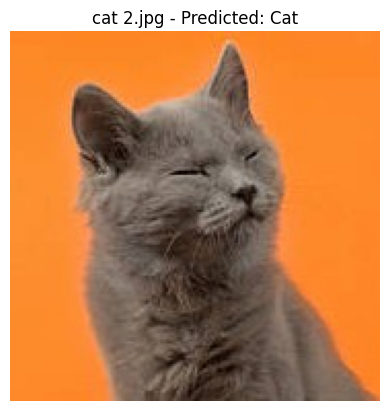

cat 2.jpg - Raw score: 0.0004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


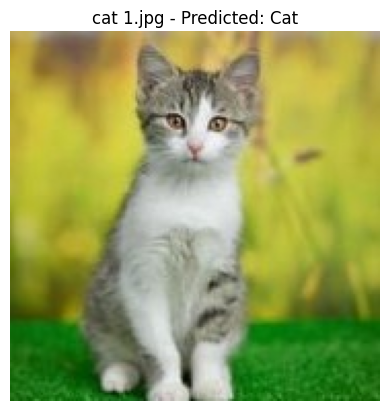

cat 1.jpg - Raw score: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


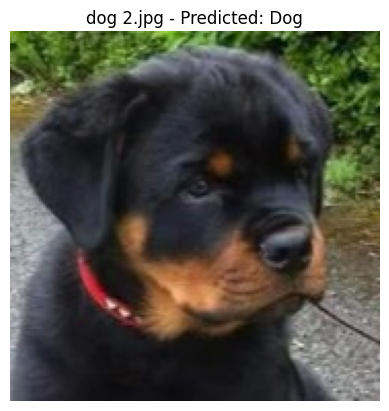

dog 2.jpg - Raw score: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


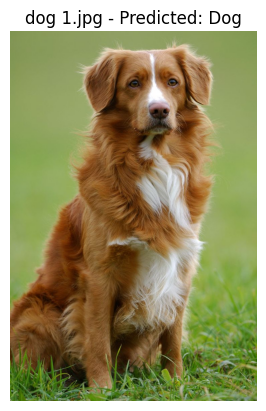

dog 1.jpg - Raw score: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


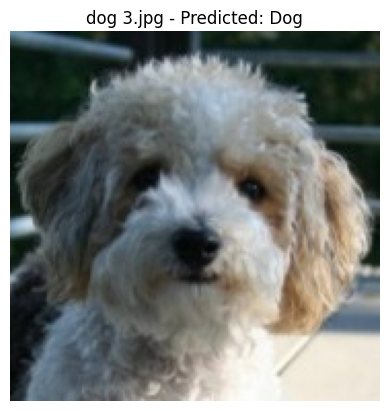

dog 3.jpg - Raw score: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


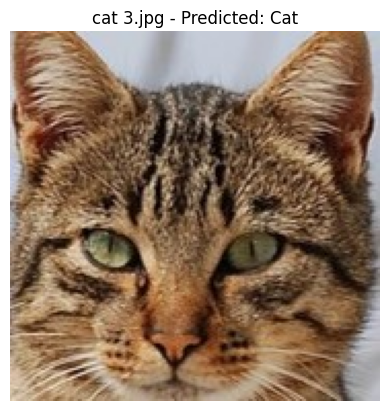

cat 3.jpg - Raw score: 0.0000


In [95]:
from tensorflow.keras.applications.resnet50 import preprocess_input

image_folder = "/content/Pets"

class_names = ['Cat', 'Dog']

for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(image_folder, filename)

        image = Image.open(image_path).convert("RGB")
        image_resized = image.resize((180, 180))
        img_array = np.expand_dims(np.array(image_resized), axis=0)
        img_array = preprocess_input(img_array)

        prediction = model.predict(img_array)
        pred_class_index = int(prediction[0][0] > 0.5)
        predicted_label = class_names[pred_class_index]

        plt.imshow(image)
        plt.title(f"{filename} - Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        print(f"{filename} - Raw score: {prediction[0][0]:.4f}")


----------------------------------------------
